# Formigó

In [1]:
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib notebook

/home/amadeu/.miniconda3/envs/arviz/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
resistencia = np.array([
    [25.5, 25.0, 25.0, 24.0, 22.5, 23.5, 24.0, 24.5, 22.5, 23.0],
    [28.5, 28.5, 26.0, 27.0, 25.5, 28.5, 27.0, 26.5, 26.0, 26.5],
    [30.5, 30.0, 29.0, 29.0, 30.0, 30.5, 28.5, 28.5, 28.0, 28.0]]
)
t = np.array([48, 60, 72])
t_aux = (t - t.mean()) / t.std()

In [3]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", 1)
    a = pm.HalfNormal("a", .05)
    b = pm.Normal("b", 0, 5)
    c = pm.Normal("c", 25, 10)
    mu = pm.Deterministic("mu", -a * t_aux**2 + b*t_aux + c)
    r = pm.Normal("r", mu=mu[:, None], sigma=sigma, observed=resistencia)
    
    trace = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 8000/8000 [04:02<00:00, 33.05draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [4]:
idata = az.from_pymc3(trace,dims={"r": ["temps", "proveta"], "mu": ["temps"]}, coords={"temps": t})

In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,2.135,0.199,1.762,2.517,0.004,0.003,2761.0,2761.0,2815.0,2229.0,1.0
c,26.763,0.197,26.376,27.121,0.004,0.003,3040.0,3034.0,3026.0,2324.0,1.0
sigma,1.077,0.145,0.824,1.355,0.003,0.002,2497.0,2442.0,2577.0,2481.0,1.0
a,0.043,0.031,0.000,0.099,0.001,0.000,2643.0,2643.0,1926.0,1571.0,1.0
mu[0],24.083,0.311,23.522,24.693,0.006,0.004,2958.0,2947.0,2980.0,2448.0,1.0
mu[1],26.763,0.197,26.376,27.121,0.004,0.003,3040.0,3034.0,3026.0,2324.0,1.0
mu[2],29.312,0.314,28.688,29.882,0.006,0.004,2946.0,2944.0,2971.0,2099.0,1.0


<IPython.core.display.Javascript object>


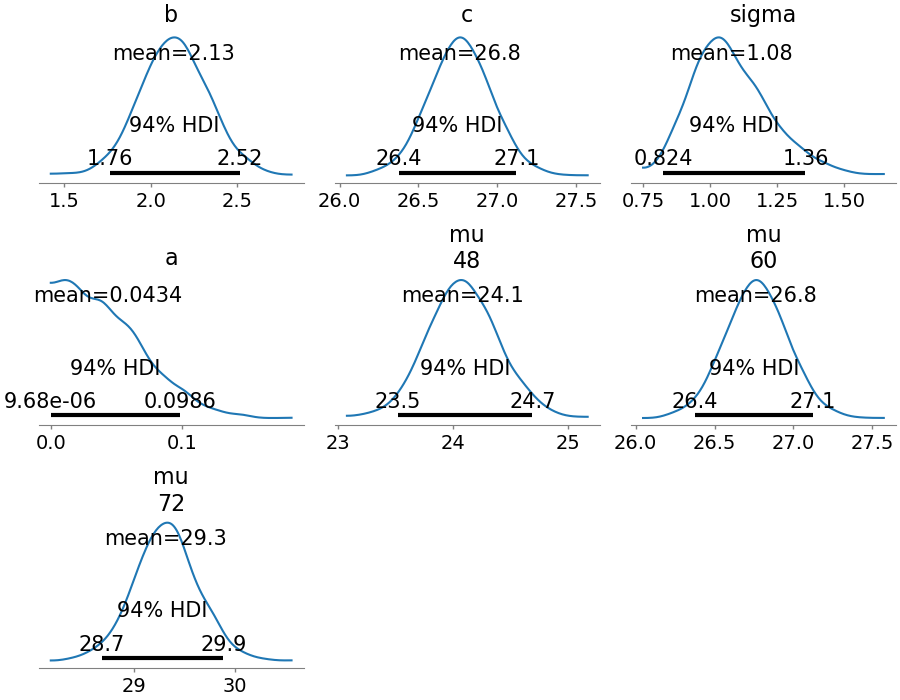

In [16]:
az.plot_posterior(idata, round_to=3, figsize=(9, 7));

In [7]:
temps_prediccions = np.arange(48, 73)
temps_aux = xr.DataArray(
    (temps_prediccions - t.mean()) / t.std(), 
    dims=["t_pred"], 
    coords={"t_pred": temps_prediccions}
)
post = idata.posterior

mu_pred = - post.a * temps_aux ** 2 + post.b * temps_aux + post.c
r_prediccions = mu_pred.copy(deep=True)
r_prediccions[:] = np.random.normal(mu_pred, post.sigma.values[:, :, None])
r_prediccions

<xarray.DataArray (chain: 2, draw: 2000, t_pred: 25)>
array([[[24.2025838 , 25.22421199, 24.70170544, ..., 29.41558751,
         28.60561917, 30.04794671],
        [24.32813423, 23.65283095, 25.97749956, ..., 29.38551436,
         30.01141491, 30.0473413 ],
        [21.94895573, 22.76605254, 25.74329449, ..., 30.3658149 ,
         31.96162371, 29.46865258],
        ...,
        [25.69682731, 24.20222185, 24.05283063, ..., 27.53860108,
         29.6319708 , 30.1958566 ],
        [26.82079443, 23.7422078 , 23.64914205, ..., 29.0396847 ,
         29.60815548, 30.60317972],
        [24.12850021, 24.17596451, 24.00872582, ..., 29.6506557 ,
         29.8963434 , 27.18818776]],

       [[24.57917318, 25.96909026, 23.23858448, ..., 28.66863606,
         29.64332554, 29.58073645],
        [23.64827666, 25.29241182, 24.91731762, ..., 27.09117412,
         27.82643121, 28.08016143],
        [22.5300837 , 25.25707821, 24.67702285, ..., 28.19899315,
         29.16050335, 30.61365073],
        ...,
        [23.0690203 , 24.5520708 , 26.00496792, ..., 30.67172304,
         30.64403262, 29.07717223],
        [25.62537045, 24.83530487, 25.4266358 , ..., 28.07336139,
         30.17155425, 29.56371264],
        [24.77636994, 23.44380264, 26.64802613, ..., 29.6591453 ,
         29.43982741, 27.8989132 ]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * t_pred   (t_pred) int64 48 49 50 51 52 53 54 55 ... 65 66 67 68 69 70 71 72

<IPython.core.display.Javascript object>


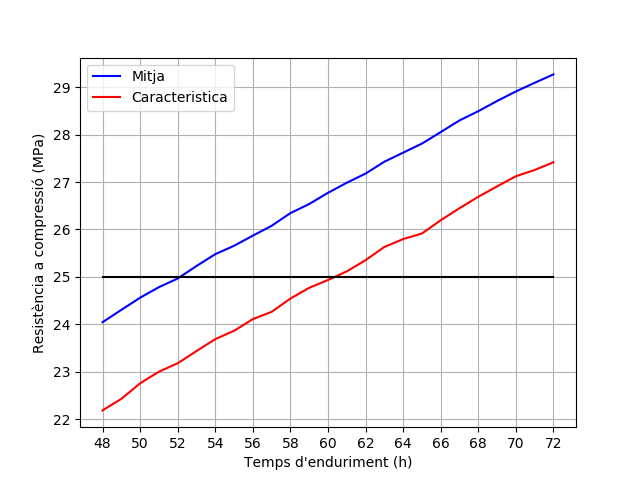

In [31]:
#az.plot_hdi(temps_prediccions, r_prediccions, hdi_prob=.9);
r_caracteristica = r_prediccions.quantile(.05, dim=("chain", "draw"))
_, ax = plt.subplots()
ax.plot(temps_prediccions, r_prediccions.mean(dim=("chain", "draw")), color="blue", label="Mitja")
ax.plot(temps_prediccions, r_caracteristica, color="red", label="Caracteristica")
ax.plot(temps_prediccions, np.full_like(temps_prediccions, 25), "k");
ax.grid(True)
ax.set_xticks(temps_prediccions[::2])
ax.set_xlabel("Temps d'enduriment (h)")
ax.set_ylabel("Resistència a compressió (MPa)")
ax.legend()

In [19]:
r_prediccions.sel(t_pred=60).quantile(.05).item()

24.933788677573535

In [21]:
az.mcse(r_prediccions.sel(t_pred=60), method="quantile", prob=.05).x.item()

0.04739620206929196

In [29]:
(r_prediccions.sel(t_pred=60) > 25).mean().item()

0.9455